In [ ]:
# SINGLE BAR MOVING 
import numpy as np 
import random
width = 304
height = 240

vel = 152  # px/s
t_period = 1 / vel  # s
l = 10

# white bar on dark background
pol = [0, 1]

randy = np.arange(height)
idx = 0
events = {"x": [], "y": [], "ts": [], "pol": [], "idx": []}
for x in np.arange(width):
    #random.shuffle(randy)
    for y in randy:
        # events is a list of tuples: (x position, y position, time in seconds, on/off polarity, idx pixel index)
        t = x / vel  # s
        # creating events
        # x
        events['x'].append(x)
        # y
        events['y'].append(y)
        # ts
        events['ts'].append(t)
        # pol
        events['pol'].append(pol[0])
        # idx
        events['idx'].append(idx)
        idx += 1
        if l < x < (width - l):
            # x
            events['x'].append(x - l)
            # y
            events['y'].append(y)
            # ts
            events['ts'].append(t)
            # pol
            events['pol'].append(pol[1])
            # idx
            events['idx'].append(idx-height*l)

In [ ]:
# Code creating random events all over the visual field simulating coherent motion

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from tempfile import TemporaryFile
import time
import os

# os.system('cls')
matplotlib.use('TkAgg')

# camera resolution
width = 50
height = 50


t = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] # s
pol = 1
events = {"x": [], "y": [], "ts": [], "pol": [], "idx": []}
frame = np.zeros((width, height))
plt.figure()
num_e = 2000

for ts in t:
    x_sample = np.random.choice(np.arange(width),  size=num_e)
    y_sample = np.random.choice(np.arange(height), size=num_e)
    for i in np.arange(len(x_sample)):
        # events is a list of tuples: (x position, y position, time in seconds, on/off polarity)
        # creating events
        # x
        events['x'].append(x_sample[i])
        # y
        events['y'].append(y_sample[i])
        # ts
        events['ts'].append(ts)
        # pol
        events['pol'].append(pol)
        # idx
        events['idx'].append(x_sample[i] * height + y_sample[i])
        frame[y_sample[i], x_sample[i]] = 1
    # Visualization
    # plt.ion()
    # plt.imshow(frame)
    # plt.draw()
    # plt.pause(0.5)
    # frame = np.zeros((width, height))


# for idx in np.arange(len(events['x'])):
#     if events['ts'][idx] < t_period:
#         frame[(events['y'][idx], events['x'][idx])] = 1
#     else:
#         ax.matshow(frame)  # or ax.imshow(frame)
#         plt.draw()
#         plt.pause(0.1)
#         frame = np.zeros((height, width))
#         frame[(events['y'][idx], events['x'][idx])] = 1


In [8]:
from brian2 import *
from brian2tools import *
%matplotlib inline

# events = np.load("events.npy", allow_pickle='TRUE').item()


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


<Axes: xlabel='time (ms)', ylabel='neuron index'>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

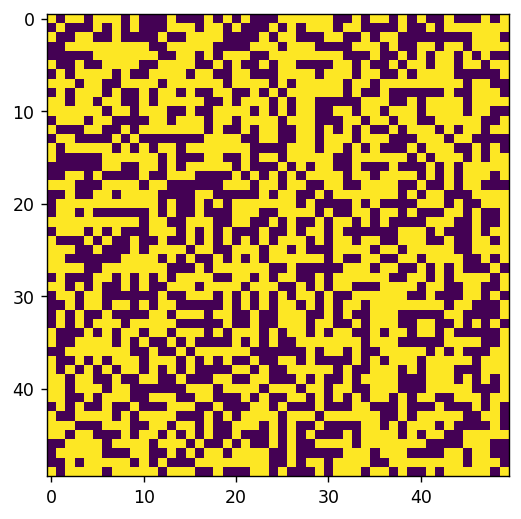

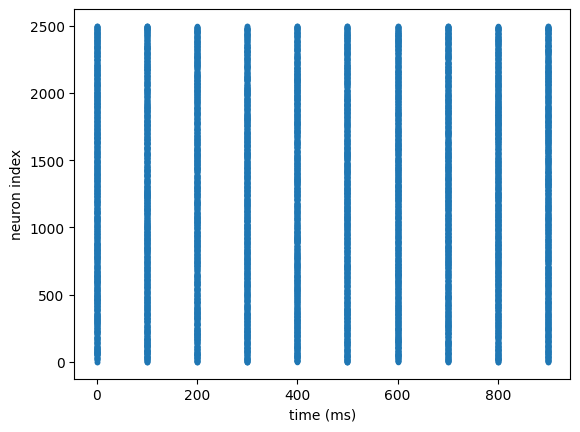

In [9]:
start_scope()

# Spike generator group simulating bipolar (BP) cells aka the events
idxs = array(events['idx'])
times = array(events['ts'])*second
N = height*width # The placement of the neurons are to cover the full visual field equally. Therefore, depending on the angle you can
# displace the number of neurons you want on each angle.
BP = SpikeGeneratorGroup(N, events['idx'], events['ts']*second)


# # NeuronGroup for creating OMS cells
# # LIF neuron
# # (unless refractory) to add if a refractory period is defined in NeuronGroup
eqs = '''
dv/dt = (I-v)/tau : 1  
I : 1
tau : second
'''

OMS = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact') # Adding a threshold and the reset to 0 after a spike. (to add RP : refractory = 3*ms)
OMS.tau = [5]*ms

# # Creating the synapse between BP and OMS
S = Synapses(BP, OMS, on_pre='v_post +=1.5')
S.connect(i='j')

spike_mon = SpikeMonitor(OMS) # Recording spikes
# # rate_mon = PopulationRateMonitor(OMS) # Recording IFR, averaged across the neurons of the group 
state_mon = StateMonitor(OMS, 'v', record = True) # Recording state variable v during a run

run(1*second)

# for i in arange(N):
#     plot(state_mon.t/ms, state_mon.v[i], label='OMS ' + str(i+1))
#     xlabel('Time (ms)')
#     ylabel('V (volt)')
#     legend()

figure()
brian_plot(spike_mon)



In [ ]:
# NeuronGroup for creating a single Amacrine Cell (A)
A = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')  # refractory=3*ms
# Setting the input for the cells.
A.I = 0
# Setting the time constant
A.tau = 10 * ms

# Excitation synapses from BP cells to the A cell
S = Synapses(B, A, on_pre='v_post +=0.6')
S.connect()


# Visualizing connectivity
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(25, 8))

    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['OMS', 'A'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))


visualise_connectivity(S)

# Inhibitory synapses from A cell to all OMS (G) cells
S = Synapses(A, B, on_pre='v_post -=0.6')
S.connect()


# Visualizing connectivity
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(25, 8))

    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['A', 'OMS'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))


visualise_connectivity(S)